## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [2]:
def print_graphs(data):
    for i in range(0, 21, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 21, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 21, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [ ]:
data = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/single/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data.shape

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/single/label_unificada.npy")[0]
print(labels, labels.shape)

In [ ]:
print(data.shape)
print(data[0].shape)
print(data[0].shape)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data[0].reshape(data[0].shape[0], 1, data[0].shape[1])
print(data_correct.shape)
# adicionando label como "épocas" do sinal
labels = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/single/label_unificada.npy")[0]
print(labels[0].shape)
new_labels = labels[0]
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(new_labels))),
    np.zeros(21, dtype=int),
    le.fit_transform(new_labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


# Criação do MNE para o multi target

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [3]:
def print_graphs(data):
    for i in range(0, 10, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [4]:
data = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/multi/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data.shape

(10, 10, 8192)


(10, 8192, 10)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

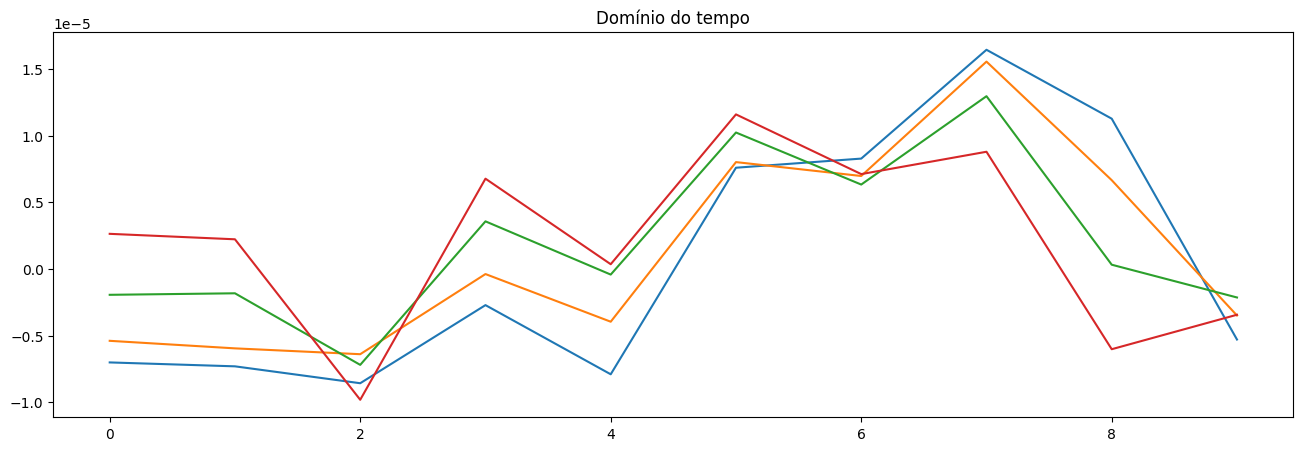

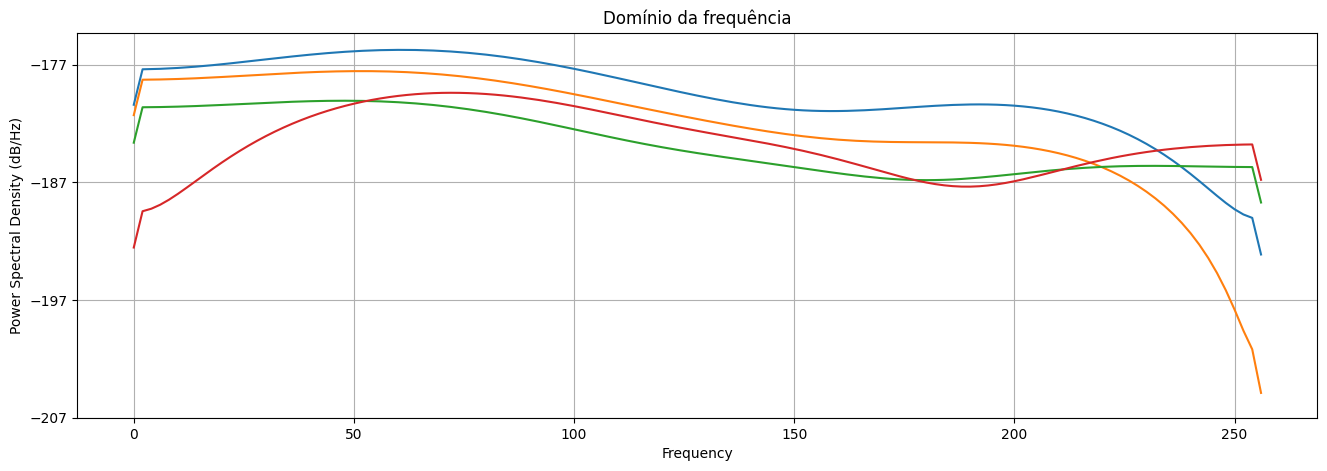

C:\Users\gregu\AppData\Local\Temp\ipykernel_11836\801008969.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=10).
  plt.specgram(data[i,:], Fs=512)


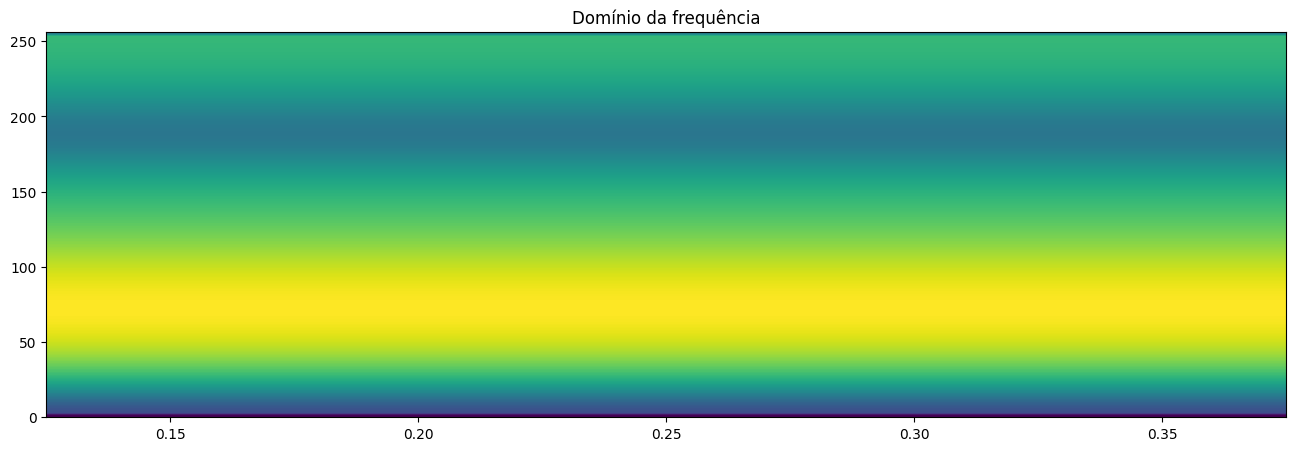

In [5]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/multi/label_unificada.npy")[0]
print(labels, labels.shape)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data[0].reshape(data[0].shape[0], 1, data[0].shape[1])
print(data_correct.shape)
# adicionando label como "épocas" do sinal
labels = np.load("C:/Users/gregu/Projetos/SSVEP/SSVEP/dataset/sc/DataSet_A_2/multi/label_unificada.npy")[0]
print(labels.shape)
new_labels = labels
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(new_labels))),
    np.zeros(10, dtype=int),
    le.fit_transform(new_labels))
)
event_dict = {'6':0, '7':1, '7.5':2, '8.2':3, '9.3':4}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

# Criação do objeto mne para os dados Single
